In [20]:
import numpy as np
import os
from scipy.linalg import schur
import tensorflow as tf
from backend.attention_network import Model
import backend as be
from backend.simulation_tools import Simulator
from backend.weight_initializer import weight_initializer
from tasks import rule_dependent_rdm as rd
import matplotlib.pyplot as plt
import time
import pickle
%matplotlib inline

In [83]:
def softmax(data):
    return np.exp(data).T/np.sum(np.exp(data),axis=1)

def relu(x):
    return np.maximum(x,0)

def state_to_output(s,w):
    o = np.zeros([s.shape[0],s.shape[1],w['b_out'].shape[0]])
    for ii in range(s.shape[1]):
        o[:,ii,:] = relu(s_[:,ii,:]).dot(w['W_out'].T) + w['b_out']
    return o

def ols(X,Y,reg=0.):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    w = np.linalg.inv(X.T.dot(X) + reg*np.eye(X.shape[1])).dot(X.T).dot(Y)
    
    return w,X.dot(w)

def run_ols(X,w):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    
    return X.dot(w)

In [3]:
n_rules = 2 #n_in = n_rules*2
n_hidden  = 250
n_out = 2
tau = 100.0 #As double
dt = 20.0  #As double
dale_ratio = None
rec_noise = 0.1
stim_noise = 0.1
batch_size = 64

cohs = [.1,.3,.7,.8,1.]
rt_version = False

#train params
learning_rate = .0001
training_iters = 200000
display_step = 20

weights_path = '../weights/rule_rdm_att_curr0.npz'

params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
                    stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
                    L2_firing_rate = .2, sample_size = 128, epochs = 100, N_rec = n_hidden, 
                    dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = rd.generate_train_trials(params)

In [4]:
#Fast Weight specific params
params['tau_fw'] = 50.       #initial time constant of fast_weights
params['gamma_train'] = True  #trainable gamma (dt/tu_fw)
params['phi_train'] = True    #trainable phi (sensitivity to fws)
params['global_phi'] = False  #Single global or synapse specific plasticity

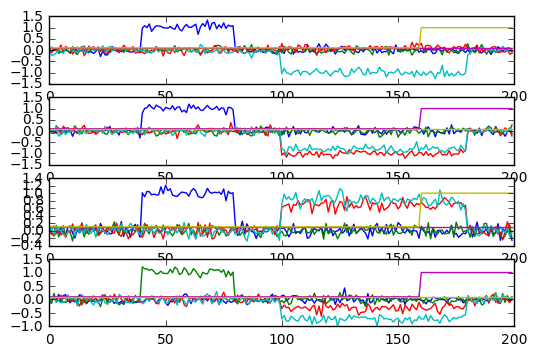

In [5]:
trial = rd.build_train_trials(params)

for ii in range(4):
    plt.subplot(4,1,ii+1)
    plt.plot(trial[0][ii,:,:])
    plt.plot(trial[1][ii,:,:])
plt.show()

In [6]:
# output_weights_path = weights_path
# params['init_type'] = 'gaussian'
# 'external weight intializer class'
# autapses = True
# w_initializer = weight_initializer(params,output_weights_path[:-4] + '_init',autapses=autapses)
# input_weights_path = w_initializer.gen_weight_dict()
# params['load_weights_path'] = input_weights_path + '.npz'


# w_init = np.load(input_weights_path + '.npz')

# plt.imshow(w_init['W_rec'],interpolation='none')

# plt.figure()
# plt.plot(w_init['W_in'])
# plt.show()


In [7]:
#regular training
if False:

    tf.reset_default_graph()
    model = Model(params)
    sess = tf.Session()
    t,att,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
                save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

    sess.close()

In [21]:
#curriculum learning
if False:

    coh_factors = np.array([.1,.05,.02]) #np.arange(1.,0,-.2)

    params['load_weights_path'] = weights_path
    training_iters = 200000


    #train loop
    for coh_factor in coh_factors:
        print coh_factor
        tf.reset_default_graph()
        params['coherences'] = coh_factor*np.array(cohs)
        if coh_factor == coh_factors[-1]:
            training_iters = 200000

        generator = rd.generate_train_trials(params)
        model = Model(params)

        sess = tf.Session()
        t,att,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
                    save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

        sess.close()

        params['load_weights_path'] = weights_path
        training_iters = 100000


    #save train params
    pickle.dump( params, open( params_path, "wb" ) )

0.1
Loading Weights
Iter 1280, Minibatch Loss= 0.005276
Norm of Phi= 0.0
Gamma= [ 0.56240529]
Norm of Grad Wrec= 0.0655564
Iter 2560, Minibatch Loss= 0.008039
Norm of Phi= 0.0
Gamma= [ 0.56216872]
Norm of Grad Wrec= 0.134437
Iter 3840, Minibatch Loss= 0.006309
Norm of Phi= 0.0
Gamma= [ 0.56238294]
Norm of Grad Wrec= 0.0608968
Iter 5120, Minibatch Loss= 0.007096
Norm of Phi= 0.0
Gamma= [ 0.56283474]
Norm of Grad Wrec= 0.0898436
Iter 6400, Minibatch Loss= 0.008168
Norm of Phi= 0.0
Gamma= [ 0.56287402]
Norm of Grad Wrec= 0.0486578
Iter 7680, Minibatch Loss= 0.004722
Norm of Phi= 0.0
Gamma= [ 0.56322342]
Norm of Grad Wrec= 0.0351487
Iter 8960, Minibatch Loss= 0.007528
Norm of Phi= 0.0
Gamma= [ 0.56313354]
Norm of Grad Wrec= 0.0621123
Iter 10240, Minibatch Loss= 0.005467
Norm of Phi= 0.0
Gamma= [ 0.5631476]
Norm of Grad Wrec= 0.0242187
Iter 11520, Minibatch Loss= 0.006147
Norm of Phi= 0.0
Gamma= [ 0.56312323]
Norm of Grad Wrec= 0.0674672
Iter 12800, Minibatch Loss= 0.010919
Norm of Phi= 0.0

NameError: name 'params_path' is not defined

Accuracy: 0.828125


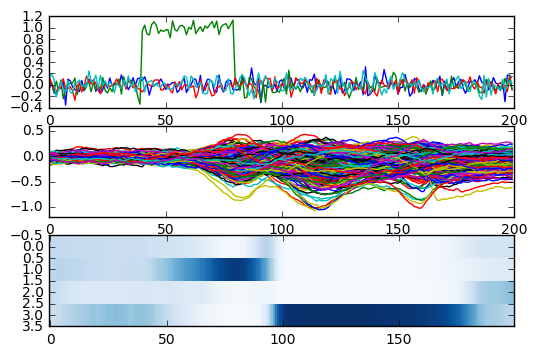

In [150]:

# t,att,phi,gamma,s,trial_data = t

w = np.load(weights_path)

# print np.asarray(att).shape
# print t
# print s[0].shape
# print trial_data[0].shape

att_ = np.asarray(att)
s_ = np.asarray(s)
o_ = state_to_output(s_,w)

rule = np.argmax(trial_data[0][:,50,:2],axis=1)
target = np.argmax(trial_data[1][:,-1,:],axis=1)
choice = np.argmax(o_[-1,:,:],axis=1)
correct = choice == target

coh = np.zeros(len(rule))
for ii in range(len(rule)):
    coh[ii] = np.mean(trial_data[0][ii,100:180,rule[ii]+2],axis=0)

print('Accuracy: {}'.format(np.mean(correct)))


trial = 1
plt.subplot(3,1,1)
plt.plot(trial_data[0][trial,:,:])
plt.subplot(3,1,2)
plt.plot(s_[:,trial,:])
plt.subplot(3,1,3)
plt.imshow(softmax(att_[:,trial,:]),aspect='auto',interpolation='none',cmap='Blues')
# plt.imshow((np.exp(att_[:,trial,:]).T/np.sum(np.exp(att_[:,trial,:]),axis=1)),aspect='auto',interpolation='none',cmap='Blues')
# plt.colorbar()
plt.legend(range(4),frameon=False,fontsize=8)
plt.show()

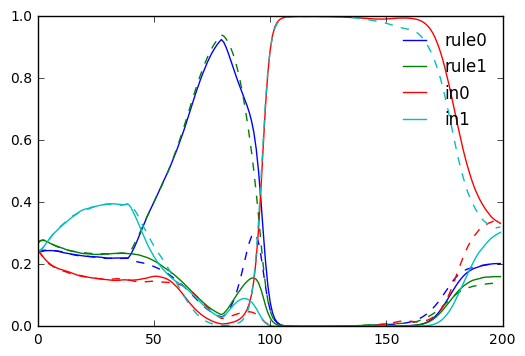

In [24]:
colors = ['b','g','r','c']

soft_att_0 = softmax(np.mean(att_[:,rule==0,:],axis=1)).T
soft_att_1 = softmax(np.mean(att_[:,rule==1,:],axis=1)).T

for ii in range(4):
    plt.plot(soft_att_0[:,ii],colors[ii])
    plt.plot(soft_att_1[:,ii],colors[ii],linestyle='--',label='_nolegend_')
    
plt.legend(['rule0','rule1','in0','in1'],frameon=False)
plt.show()

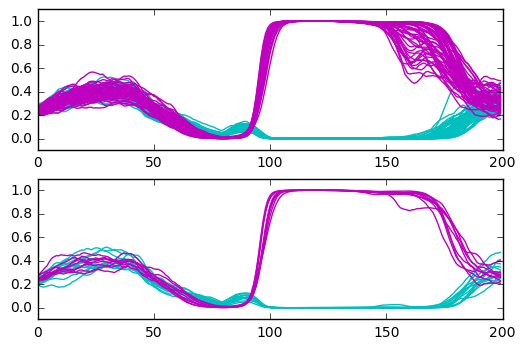

In [127]:
soft_att = np.zeros(att_.shape)
for ii in range(soft_att.shape[1]):
    soft_att[:,ii,:] = softmax(att_[:,ii,:]).T
    

plt.subplot(2,1,1)
plt.plot(soft_att[:,np.logical_and(rule==0,correct),3],'c')
plt.plot(soft_att[:,np.logical_and(rule==1,correct),3],'m')
plt.ylim([-.1,1.1])

plt.subplot(2,1,2)
plt.plot(soft_att[:,np.logical_and(rule==0,~correct),3],'c')
plt.plot(soft_att[:,np.logical_and(rule==1,~correct),3],'m')
plt.ylim([-.1,1.1])
plt.show()

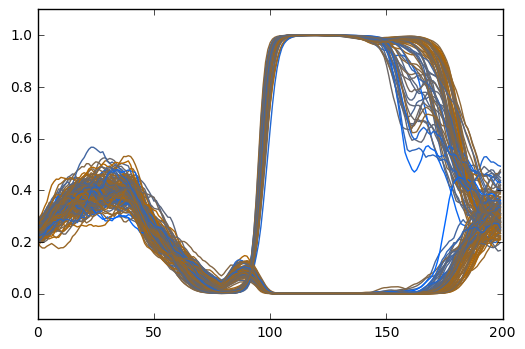

In [149]:
norm_coh = (np.abs(coh)-np.min(np.abs(coh)))/(np.max(np.abs(coh))-np.min(np.abs(coh)))

for ii in range(len(norm_coh)):
    plt.plot(soft_att[:,ii,3],color=[.7-.7*norm_coh[ii],.4,norm_coh[ii]])
    

plt.ylim([-.1,1.1])
plt.show()